# Ship Detection with U-Net Segmentation

## Model Parameters
We might want to adjust these later (or do some hyperparameter optimizations)

In [1]:
BATCH_SIZE = 48
EDGE_CROP = 16
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = (1, 1)
# downsampling in preprocessing
IMG_SCALING = (3, 3)
# number of validation images to use
VALID_IMG_COUNT = 900
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 20
MAX_TRAIN_EPOCHS = 50
AUGMENT_BRIGHTNESS = False

In [2]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries
from skimage.util.montage import montage2d as montage
from skimage.morphology import binary_opening, disk, label
import gc; gc.enable() # memory is tight

montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = './airbus'
train_image_dir = os.path.join(ship_dir, 'train')
test_image_dir = os.path.join(ship_dir, 'test')

def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

In [3]:
masks = pd.read_csv(os.path.join('./airbus/', 'train_ship_segmentations.csv'))
not_empty = pd.notna(masks.EncodedPixels)
print(not_empty.sum(), 'masks in', masks[not_empty].ImageId.nunique(), 'images')
print((~not_empty).sum(), 'empty images in', masks.ImageId.nunique(), 'total images')

56030 masks in 29070 images
75000 empty images in 104070 total images


# Check RLE Encoding / Decoding

In [4]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (16, 5))
rle_0 = masks.query('ImageId=="00021ddc3.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0)
ax1.set_title('Mask as image')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1)
ax2.set_title('Re-encoded')
img_c = masks_as_color(rle_0)
ax3.imshow(img_c)
ax3.set_title('Masks in colors')
img_c = masks_as_color(rle_1)
ax4.imshow(img_c)
ax4.set_title('Re-encoded in colors')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))
print(np.sum(img_0 - img_1), 'encoding / decoding errors')

Check Decoding->Encoding RLE_0: 9 -> RLE_1: 4
0 encoding / decoding errors


# Split into training and validation groups

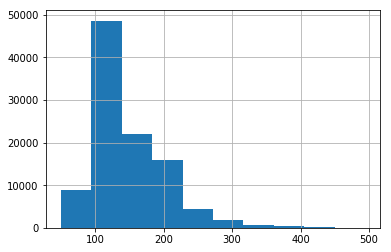

In [5]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
# some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: os.stat(os.path.join(train_image_dir, c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] > 50] # keep only +50kb files
unique_img_ids['file_size_kb'].hist()
exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg', 
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] # corrupted images  
unique_img_ids = unique_img_ids[~unique_img_ids['ImageId'].isin(exclude_list)]
masks.drop(['ships'], axis=1, inplace=True)

### Examine Number of Ship Images

In [6]:
unique_img_ids.count()

ImageId         103317
ships           103317
has_ship        103317
has_ship_vec    103317
file_size_kb    103317
dtype: int64

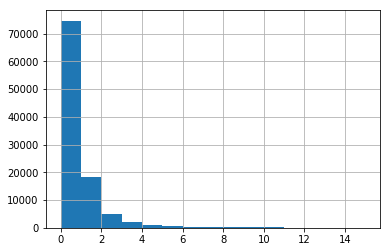

In [7]:
"""Distribution of number of ships per image"""
unique_img_ids['ships'].hist(bins=unique_img_ids['ships'].max())

# Undersample Empty Images

11256 masks


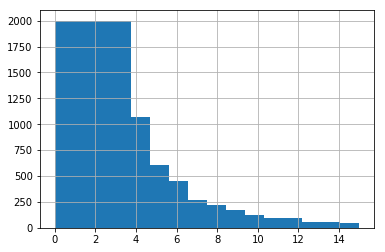

In [8]:
SAMPLES_PER_GROUP = 2000
balanced_train_df = unique_img_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1)
print(balanced_train_df.shape[0], 'masks')

In [9]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(balanced_train_df, 
                 test_size = 0.1, 
                 stratify = balanced_train_df['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

31311 training masks
3482 validation masks


# Decode all the RLEs into Images with image generator

In [10]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = imread(rgb_path)
            c_mask = np.expand_dims(masks_as_image(c_masks['EncodedPixels'].values), -1)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

In [11]:
train_gen = make_image_gen(train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (48, 256, 256, 3) 0.0 1.0
y (48, 256, 256, 1) 0 1


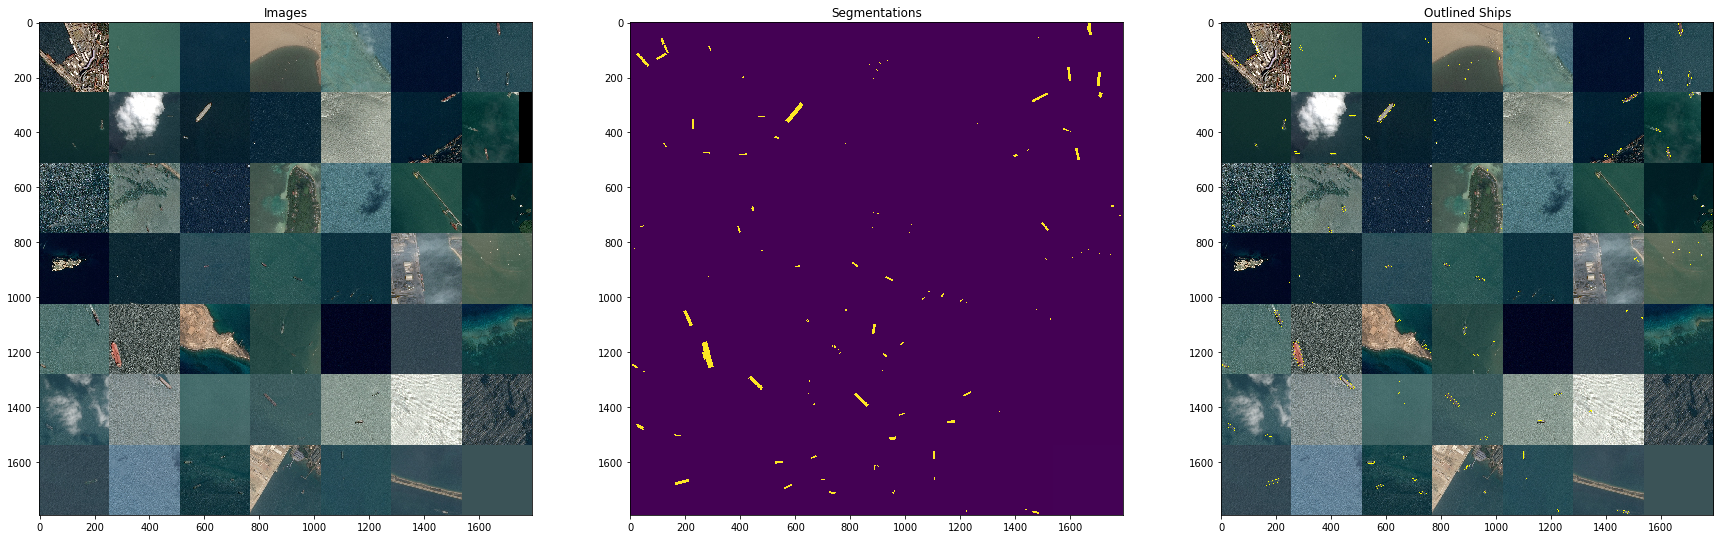

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, 
                           batch_seg.astype(int)))
ax3.set_title('Outlined Ships')
fig.savefig('DataPreparationOverview.png')

# Make the Validation Set

In [13]:
%%time
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

(900, 256, 256, 3) (900, 256, 256, 1)
Wall time: 21.2 s


# Augment Data

In [14]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')
# brightness can be problematic since it seems to change the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


x (48, 256, 256, 3) float32 0.0 1.0
y (48, 256, 256, 1) float32 0.0 1.0


Text(0.5,1,'segmented ships')

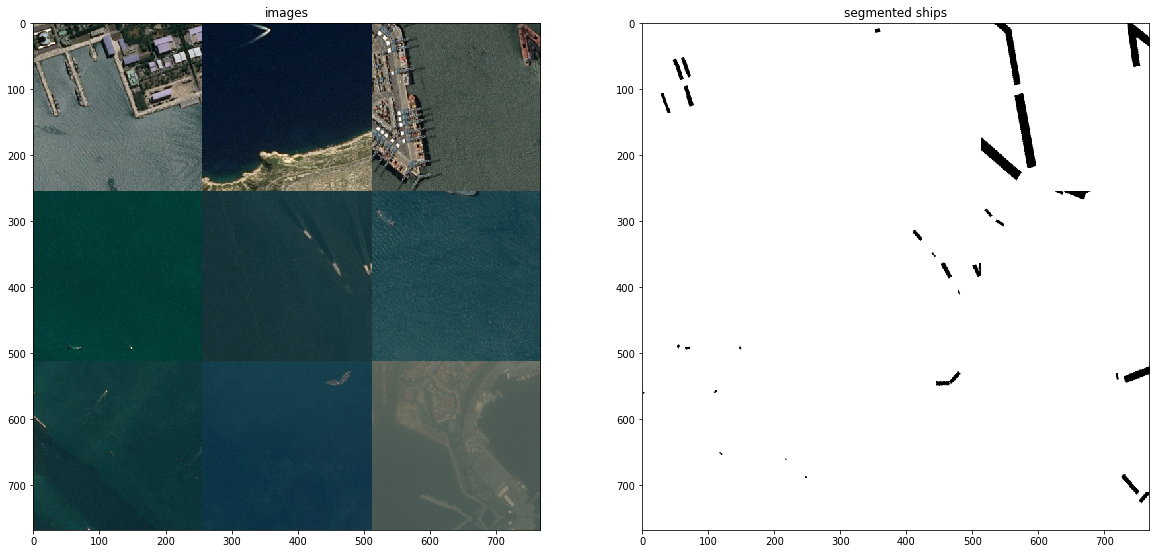

In [15]:
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x), cmap='gray')
ax1.set_title('images')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray_r')
ax2.set_title('segmented ships')

In [16]:
gc.collect()

17

# U-Net Model

In [17]:
from keras import models, layers
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    
input_img = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img

if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
    
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (pp_in_layer)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = layers.MaxPooling2D((2, 2)) (c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

d = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)
if NET_SCALING is not None:
    d = layers.UpSampling2D(NET_SCALING)(d)

seg_model = models.Model(inputs=[input_img], outputs=[d])

In [18]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

## intersection over union
def IoU(y_true, y_pred, eps=1e-6):
    if np.max(y_true) == 0.0:
        return IoU(1-y_true, 1-y_pred) ## empty image; calc IoU of zeros
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return -K.mean( (intersection + eps) / (union + eps), axis=0)

In [19]:
#https://www.kaggle.com/krishanudb/keras-based-unet-model-construction-tutorial

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

In [22]:
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/(K.sum(y_true)+ K.epsilon())

def confusion(y_true, y_pred):
    y_pred_true = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_true
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_true) / (K.sum(y_true)+ K.epsilon())
    tn = K.sum(y_neg * y_pred_neg) / (K.sum(y_neg)+ K.epsilon())
    return {'true_pos': tp, 'true_neg': tn}

In [23]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.33,
                                   patience=1, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-8)

early = EarlyStopping(monitor="val_loss", mode="min", verbose=2,
                      patience=15)

callbacks_list = [checkpoint, early, reduceLROnPlat]

In [24]:
from keras.optimizers import sgd

In [25]:
def fit():
    seg_model.compile(optimizer=sgd(1e-3, decay=1e-6), loss='binary_crossentropy', metrics=['binary_accuracy', dice_coef, true_positive_rate])
    
    step_count = min(MAX_TRAIN_STEPS, train_df.shape[0]//BATCH_SIZE)
    aug_gen = create_aug_gen(make_image_gen(train_df))
    loss_history = [seg_model.fit_generator(aug_gen,
                                 steps_per_epoch=step_count,
                                 epochs=MAX_TRAIN_EPOCHS,
                                 validation_data=(valid_x, valid_y),
                                 callbacks=callbacks_list,
                                workers=1 # the generator is not very thread safe
                                           )]
    return loss_history

while True:
    loss_history = fit()
    if np.min([mh.history['val_loss'] for mh in loss_history]) < -0.2:
        break

Epoch 1/50
20/20 [==============================] - 498s 25s/step - loss: 0.6686 - binary_accuracy: 0.9643 - dice_coef: 0.8095 - true_positive_rate: 0.0248 - val_loss: 0.6747 - val_binary_accuracy: 0.9874 - val_dice_coef: 0.8070 - val_true_positive_rate: 0.0043

Epoch 00001: val_loss improved from inf to 0.67471, saving model to seg_model_weights.best.hdf5
Epoch 2/50
20/20 [==============================] - 539s 27s/step - loss: 0.6598 - binary_accuracy: 0.9900 - dice_coef: 0.8120 - true_positive_rate: 0.0033 - val_loss: 0.6658 - val_binary_accuracy: 0.9948 - val_dice_coef: 0.8105 - val_true_positive_rate: 2.4770e-04

Epoch 00002: val_loss improved from 0.67471 to 0.66582, saving model to seg_model_weights.best.hdf5
Epoch 3/50
20/20 [==============================] - 536s 27s/step - loss: 0.6502 - binary_accuracy: 0.9928 - dice_coef: 0.8150 - true_positive_rate: 3.6619e-04 - val_loss: 0.6554 - val_binary_accuracy: 0.9949 - val_dice_coef: 0.8135 - val_true_positive_rate: 3.0142e-05

Epo

20/20 [==============================] - 487s 24s/step - loss: 0.1870 - binary_accuracy: 0.9930 - dice_coef: 0.9706 - true_positive_rate: 0.0000e+00 - val_loss: 0.2052 - val_binary_accuracy: 0.9949 - val_dice_coef: 0.9645 - val_true_positive_rate: 0.0000e+00

Epoch 00023: val_loss improved from 0.22508 to 0.20520, saving model to seg_model_weights.best.hdf5
Epoch 24/50
20/20 [==============================] - 487s 24s/step - loss: 0.1694 - binary_accuracy: 0.9930 - dice_coef: 0.9754 - true_positive_rate: 0.0000e+00 - val_loss: 0.1872 - val_binary_accuracy: 0.9949 - val_dice_coef: 0.9697 - val_true_positive_rate: 0.0000e+00

Epoch 00024: val_loss improved from 0.20520 to 0.18718, saving model to seg_model_weights.best.hdf5
Epoch 25/50
20/20 [==============================] - 486s 24s/step - loss: 0.1513 - binary_accuracy: 0.9930 - dice_coef: 0.9799 - true_positive_rate: 0.0000e+00 - val_loss: 0.1715 - val_binary_accuracy: 0.9949 - val_dice_coef: 0.9738 - val_true_positive_rate: 0.0000e+

20/20 [==============================] - 595s 30s/step - loss: 0.0521 - binary_accuracy: 0.9934 - dice_coef: 0.9968 - true_positive_rate: 0.0000e+00 - val_loss: 0.0640 - val_binary_accuracy: 0.9949 - val_dice_coef: 0.9945 - val_true_positive_rate: 0.0000e+00

Epoch 00045: val_loss improved from 0.06540 to 0.06398, saving model to seg_model_weights.best.hdf5
Epoch 46/50
20/20 [==============================] - 696s 35s/step - loss: 0.0500 - binary_accuracy: 0.9935 - dice_coef: 0.9969 - true_positive_rate: 0.0000e+00 - val_loss: 0.0626 - val_binary_accuracy: 0.9949 - val_dice_coef: 0.9947 - val_true_positive_rate: 0.0000e+00

Epoch 00046: val_loss improved from 0.06398 to 0.06264, saving model to seg_model_weights.best.hdf5
Epoch 47/50
20/20 [==============================] - 525s 26s/step - loss: 0.0528 - binary_accuracy: 0.9930 - dice_coef: 0.9967 - true_positive_rate: 0.0000e+00 - val_loss: 0.0618 - val_binary_accuracy: 0.9949 - val_dice_coef: 0.9948 - val_true_positive_rate: 0.0000e+

KeyboardInterrupt: 

In [26]:
seg_model.load_weights(weight_path)
seg_model.save('seg_model.h5')

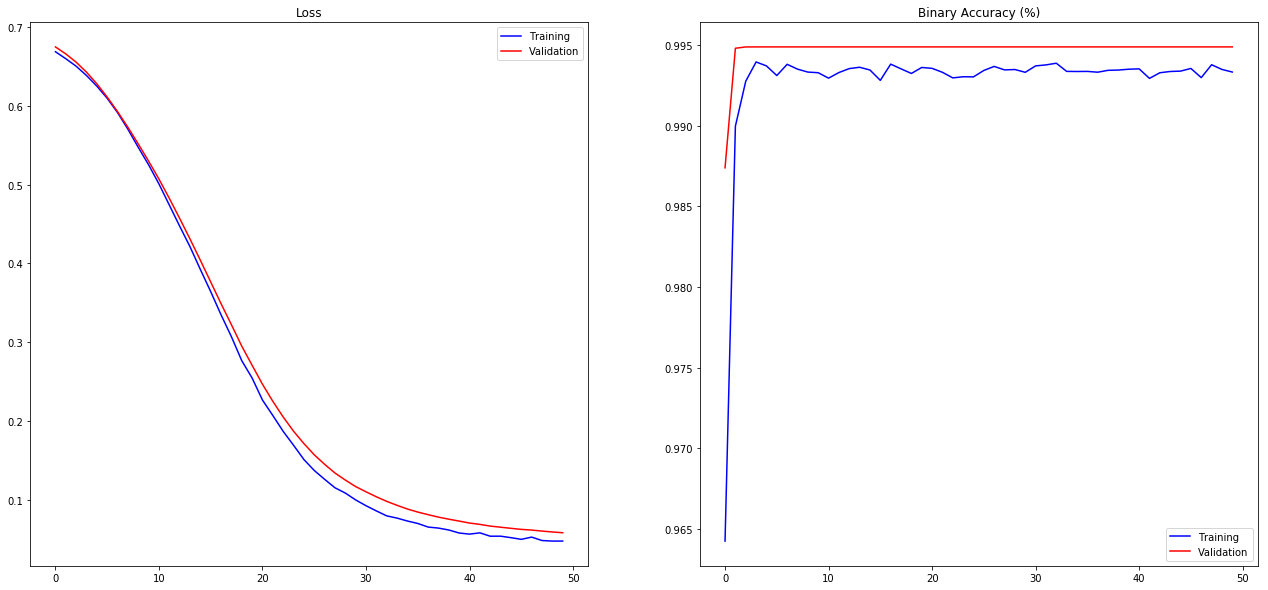

In [27]:
def show_loss(loss_history):
    epochs = np.concatenate([mh.epoch for mh in loss_history])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))
    
    _ = ax1.plot(epochs, np.concatenate([mh.history['loss'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')
    
    _ = ax2.plot(epochs, np.concatenate([mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_binary_accuracy'] for mh in loss_history]), 'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('Binary Accuracy (%)')
    fig.savefig('lossaccuracy.png')

show_loss(loss_history)


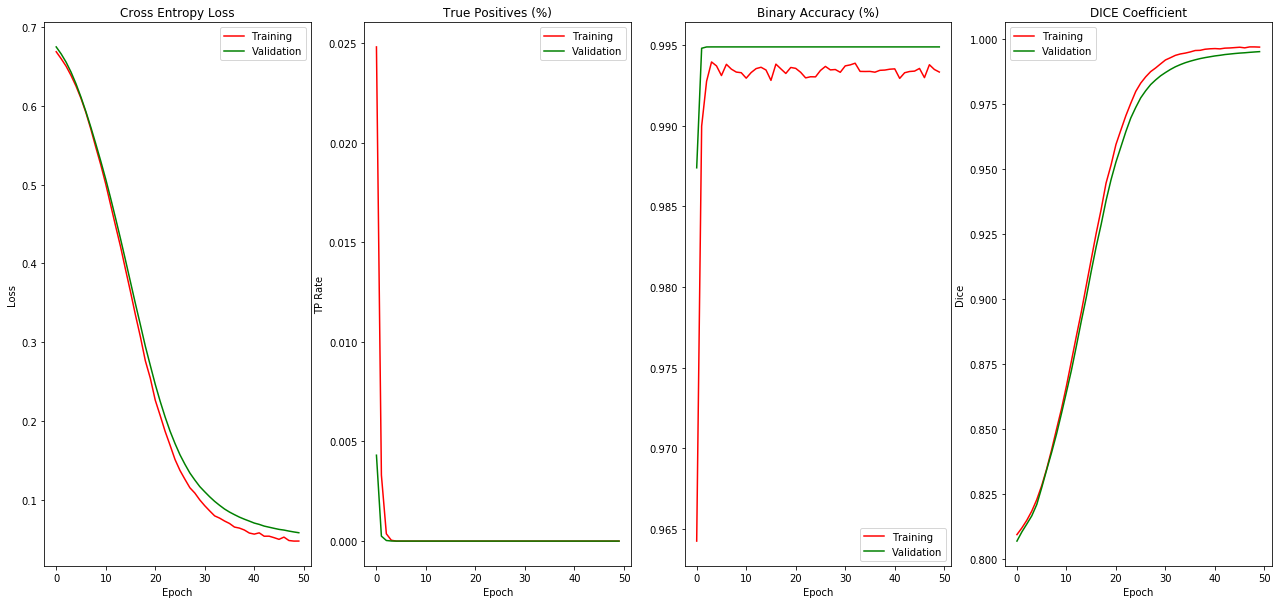

In [39]:
def show_loss(loss_history):
    epochs = np.concatenate([mh.epoch for mh in loss_history])
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epochs,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'r-',
                 epochs, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'g-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Cross Entropy Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')

    _ = ax2.plot(epochs, np.concatenate(
        [mh.history['true_positive_rate'] for mh in loss_history]), 'r-',
                     epochs, np.concatenate(
            [mh.history['val_true_positive_rate'] for mh in loss_history]),
                     'g-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('TP Rate')
    ax2.set_title('True Positives (%)')

    _ = ax3.plot(epochs, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'r-',
                     epochs, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'g-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    ax3.set_xlabel('Epoch')
    
    _ = ax4.plot(epochs, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'r-',
                     epochs, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'g-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE Coefficient')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Dice')
    fig.savefig('losshistory2.png')

show_loss(loss_history)

In [29]:
pred_y = seg_model.predict(valid_x)
print(pred_y.shape, pred_y.min(axis=0).max(), pred_y.max(axis=0).min(), pred_y.mean())

(900, 256, 256, 1) 0.14056914 0.1617623 0.03038671


# Full Resolution Model

In [30]:
if IMG_SCALING is not None:
    fullres_model = models.Sequential()
    fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
    fullres_model.add(seg_model)
    fullres_model.add(layers.UpSampling2D(IMG_SCALING))
else:
    fullres_model = seg_model
fullres_model.save('fullres_model.h5')

# Visualize predictions

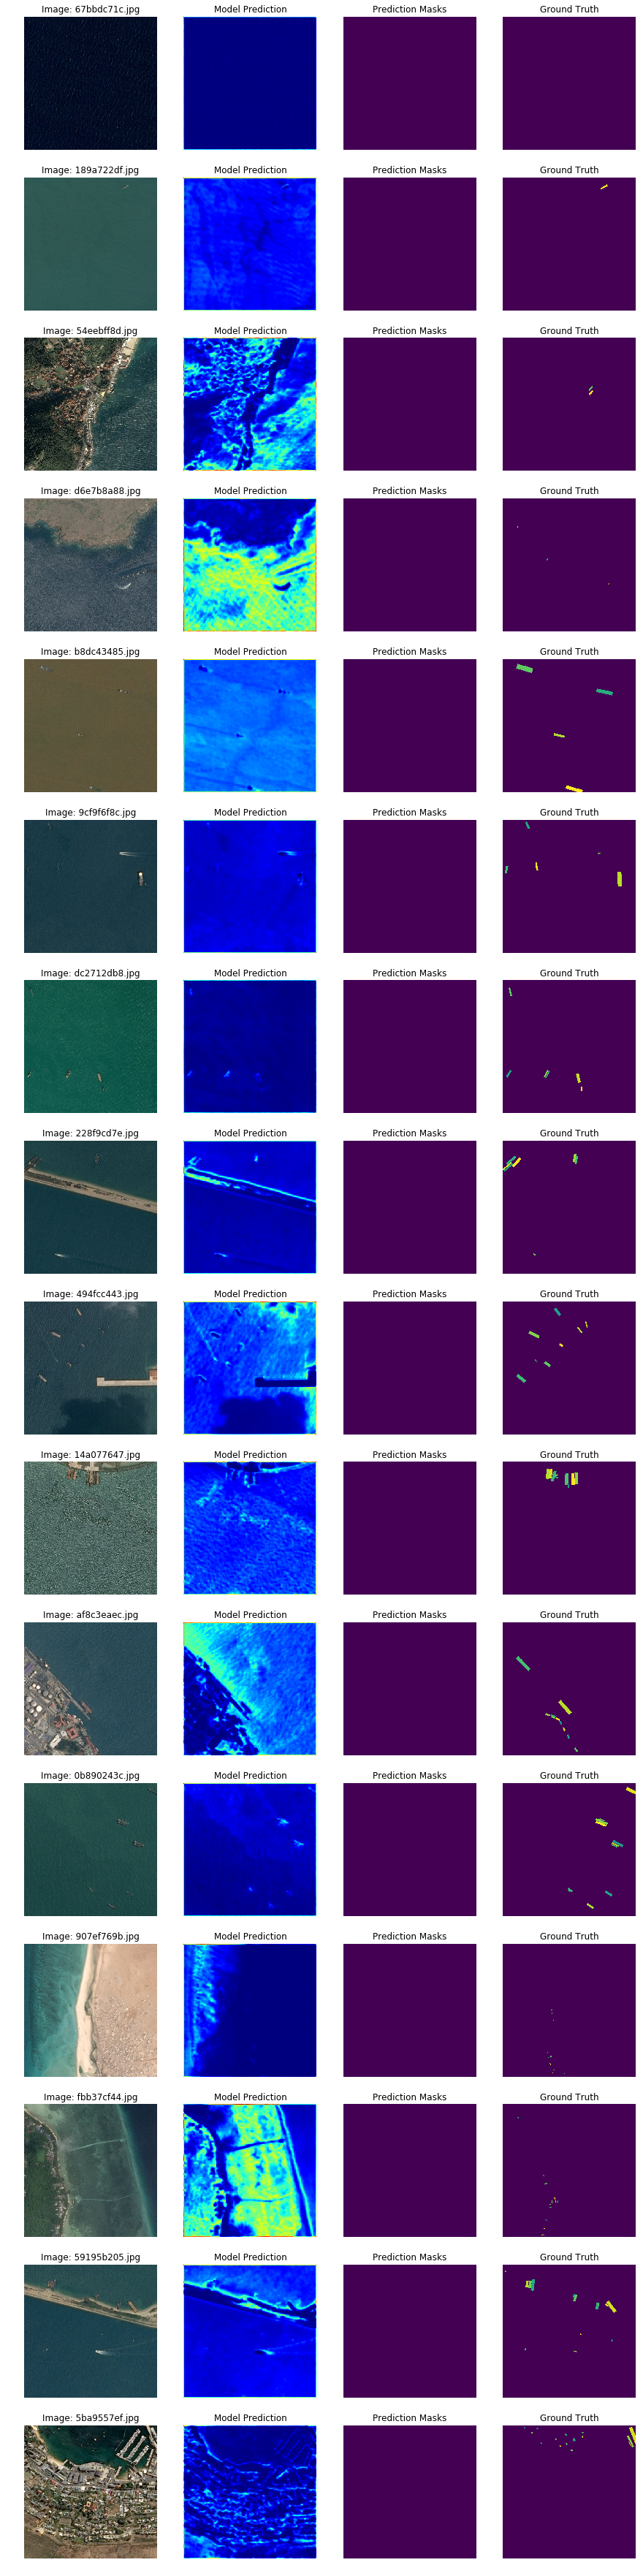

In [31]:
def raw_prediction(img, path=test_image_dir):
    c_img = imread(os.path.join(path, c_img_name))
    c_img = np.expand_dims(c_img, 0)/255.0
    cur_seg = fullres_model.predict(c_img)[0]
    return cur_seg, c_img[0]

def smooth(cur_seg):
    return binary_opening(cur_seg>0.99, np.expand_dims(disk(2), -1))

def predict(img, path=test_image_dir):
    cur_seg, c_img = raw_prediction(img, path=path)
    return smooth(cur_seg), c_img

samples = valid_df.groupby('ships').apply(lambda x: x.sample(1))
fig, m_axs = plt.subplots(samples.shape[0], 4, figsize = (15, samples.shape[0]*4))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2, ax3, ax4), c_img_name in zip(m_axs, samples.ImageId.values):
    first_seg, first_img = raw_prediction(c_img_name, train_image_dir)
    ax1.imshow(first_img)
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(first_seg[:, :, 0], cmap=get_cmap('jet'))
    ax2.set_title('Model Prediction')
    reencoded = masks_as_color(multi_rle_encode(smooth(first_seg)[:, :, 0]))
    ax3.imshow(reencoded)
    ax3.set_title('Prediction Masks')
    ground_truth = masks_as_color(masks.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels'])
    ax4.imshow(ground_truth)
    ax4.set_title('Ground Truth')
    
fig.savefig('validation.png')

# Submission

In [32]:
test_paths = np.array(os.listdir(test_image_dir))
print(len(test_paths), 'test images found')

15606 test images found


In [33]:
from tqdm import tqdm_notebook

def pred_encode(img, **kwargs):
    cur_seg, _ = predict(img)
    cur_rles = multi_rle_encode(cur_seg, **kwargs)
    return [[img, rle] for rle in cur_rles if rle is not None]

out_pred_rows = []
for c_img_name in tqdm_notebook(test_paths[:10]): ## subset
    out_pred_rows += pred_encode(c_img_name, min_max_threshold=1.0)

15606 test images found


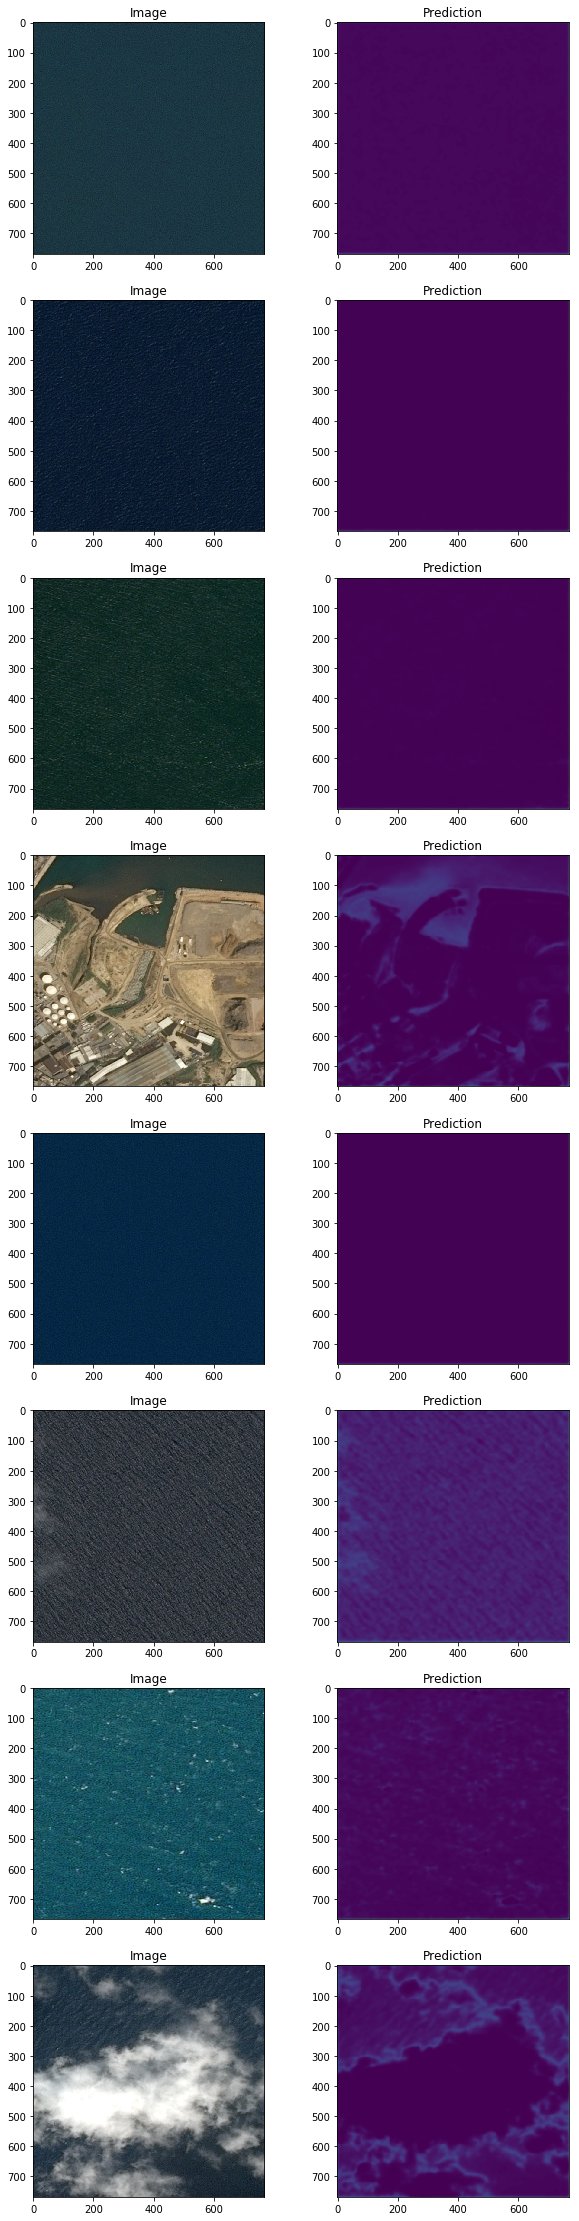

In [36]:
test_paths = np.array(os.listdir(test_image_dir))
print(len(test_paths), 'test images found')

fig, m_axs = plt.subplots(8, 2, figsize = (10, 40))
for (ax1, ax2), c_img_name in zip(m_axs, test_paths):
    c_path = os.path.join(test_image_dir, c_img_name)
    c_img = imread(c_path)
    first_img = np.expand_dims(c_img, 0)/255.0
    first_seg = fullres_model.predict(first_img)
    ax1.imshow(first_img[0])
    ax1.set_title('Image')
    ax2.imshow(first_seg[0, :, :, 0], vmin = 0, vmax = 1)
    ax2.set_title('Prediction')
fig.savefig('test_predictions.png')


In [37]:
import sys
from time import sleep
from tqdm import tqdm


#from tqdm import tqdm_notebook
from skimage.morphology import binary_opening, disk
out_pred_rows = []
for c_img_name in tqdm(test_paths):
    c_path = os.path.join(test_image_dir, c_img_name)
    c_img = imread(c_path)
    c_img = np.expand_dims(c_img, 0)/255.0
    cur_seg = fullres_model.predict(c_img)[0]
    cur_seg = binary_opening(cur_seg>0.5, np.expand_dims(disk(2), -1))
    cur_rles = multi_rle_encode(cur_seg)
    if len(cur_rles)>0:
        for c_rle in cur_rles:
            out_pred_rows += [{'ImageId': c_img_name, 'EncodedPixels': c_rle}]
    else:
        out_pred_rows += [{'ImageId': c_img_name, 'EncodedPixels': None}]
    gc.collect()


submission_df = pd.DataFrame(out_pred_rows)[['ImageId', 'EncodedPixels']]
submission_df.to_csv('submission_T.csv', index=False)
submission_df.sample(3)


"""Prediction of preclassified data set """
column_names = ['ImageId']
shiplist05 = pd.read_csv('filtered_ships_05_v2.txt', header=None, names = column_names)
shiplist05 = shiplist05.ImageId.values
shiplist05

shiplist04 = pd.read_csv('filtered_ships_04_v2.txt', header=None, names = column_names)
shiplist04 = shiplist04.ImageId.values
shiplist04
## Submit preclassified data threshold 0.5

from skimage.morphology import binary_opening, disk
out_pred_rows = []
for c_img_name in tqdm(shiplist05):
    c_path = os.path.join(test_image_dir, c_img_name)
    c_img = imread(c_path)
    c_img = np.expand_dims(c_img, 0)/255.0
    cur_seg = fullres_model.predict(c_img)[0]
    cur_seg = binary_opening(cur_seg>0.5, np.expand_dims(disk(2), -1))
    cur_rles = multi_rle_encode(cur_seg)
    if len(cur_rles)>0:
        for c_rle in cur_rles:
            out_pred_rows += [{'ImageId': c_img_name, 'EncodedPixels': c_rle}]
    else:
        out_pred_rows += [{'ImageId': c_img_name, 'EncodedPixels': None}]
    gc.collect()

sub = pd.DataFrame(out_pred_rows)[['ImageId', 'EncodedPixels']]
sub.sample(3)


sub1 = pd.read_csv('./airbus/sample_submission.csv')
sub1 = pd.DataFrame(np.setdiff1d(sub1['ImageId'].unique(), sub['ImageId'].unique(), assume_unique=True), columns=['ImageId'])
sub1['EncodedPixels'] = None
print(len(sub1), len(sub))

sub = pd.concat([sub, sub1])
print(len(sub))
sub.to_csv('submission_P5.csv', index=False)
sub.head()

## Submit preclassified data threshold 0.4
     
from skimage.morphology import binary_opening, disk
out_pred_rows = []
for c_img_name in tqdm(shiplist04):
    c_path = os.path.join(test_image_dir, c_img_name)
    c_img = imread(c_path)
    c_img = np.expand_dims(c_img, 0)/255.0
    cur_seg = fullres_model.predict(c_img)[0]
    cur_seg = binary_opening(cur_seg>0.5, np.expand_dims(disk(2), -1))
    cur_rles = multi_rle_encode(cur_seg)
    if len(cur_rles)>0:
        for c_rle in cur_rles:
            out_pred_rows += [{'ImageId': c_img_name, 'EncodedPixels': c_rle}]
    else:
        out_pred_rows += [{'ImageId': c_img_name, 'EncodedPixels': None}]
    gc.collect()

sub = pd.DataFrame(out_pred_rows)[['ImageId', 'EncodedPixels']]
sub.sample(3)


sub1 = pd.read_csv('./airbus/sample_submission.csv')
sub1 = pd.DataFrame(np.setdiff1d(sub1['ImageId'].unique(), sub['ImageId'].unique(), assume_unique=True), columns=['ImageId'])
sub1['EncodedPixels'] = None
print(len(sub1), len(sub))

sub = pd.concat([sub, sub1])
print(len(sub))
sub.to_csv('submission_P4.csv', index=False)
sub.head()

100%|██████████████████████████████████████████████████████████████████████████████| 5414/5414 [45:22<00:00,  2.13it/s]


1 5414
5415


100%|██████████████████████████████████████████████████████████████████████████| 10167/10167 [1:22:28<00:00,  2.14it/s]


1 10167
10168


ImageId EncodedPixels
0  34277b467.jpg          None
1  9a64bbaec.jpg          None
2  ccc9c5949.jpg          None
3  18a45a95b.jpg          None
4  9eff21135.jpg          None